Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1FllL2kWZ5q1E0alqyLz7TGC1qlKYwJxN'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1pJS8Cc_AeixyHXgXm9uB_KaboX5E-G40'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1IYIIMhI1uQNjxlp9D4WzEBKLk20gE6RC'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1817
Number of dev sentences:  321
Number of test sentences:  378
Number of words in the training dataset:  11597
Number of words in the dev dataset:  4202
Number of words in the test dataset:  5076
Tags in the training dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the training dataset:  3
Tags in the dev dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the dev dataset:  3
Tags in the test dataset: ['I-LEGISLACAO', 'B-LEGISLACAO', 'O']
Number of Labels in the test dataset:  3
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 671,“,O
1,Sentence: 671,Agravo,O
2,Sentence: 671,regimental,O
3,Sentence: 671,em,O
4,Sentence: 671,habeas,O
5,Sentence: 671,corpus,O
6,Sentence: 671,.,O
7,Sentence: 671,Homicídio,O
8,Sentence: 671,qualificado,O
9,Sentence: 671,(,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('em', 'O'),
 ('seus', 'O'),
 ('votos', 'O'),
 ('os', 'O'),
 ('argumentos', 'O'),
 ('de', 'O'),
 ('ambas', 'O'),
 ('as', 'O'),
 ('partes', 'O'),
 (',', 'O'),
 ('não', 'O'),
 ('havendo', 'O'),
 ('reconhecer', 'O'),
 (',', 'O'),
 ('agora', 'O'),
 (',', 'O'),
 ('quaisquer', 'O'),
 ('dos', 'O'),
 ('vícios', 'O'),
 ('do', 'O'),
 ('art.', 'B-LEGISLACAO'),
 ('1.022', 'I-LEGISLACAO'),
 (',', 'O'),
 ('do', 'O'),
 ('Código', 'B-LEGISLACAO'),
 ('de', 'I-LEGISLACAO'),
 ('Processo', 'I-LEGISLACAO'),
 ('Civil', 'I-LEGISLACAO'),
 ('.', 'O')]

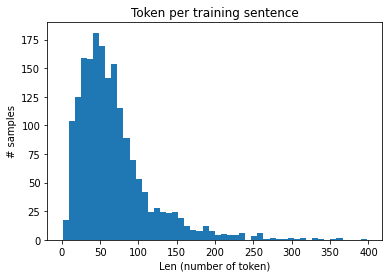

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

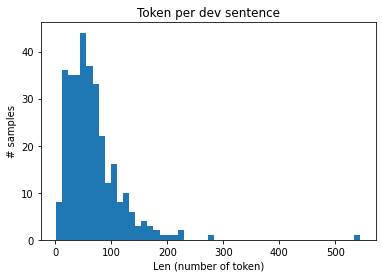

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

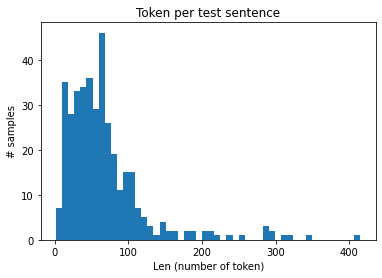

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'civil'
print(word2idx['civil'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-LEGISLACAO'
print(tag2idx['B-LEGISLACAO'])
# Tag of index 0
print(idx2tag[0])

4197
Consta
1
I-LEGISLACAO


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.95)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1817
Points in y_train before removal: 1817
Points in X_train before removal: 1817
Points in y_train before removal: 1817


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 12743, 2724, 8981, 2891, 13404, 2177, 8734, 3701, 2654, 2294, 2786, 2423, 13441, 2129, 8981, 11899, 3329, 13441, 9883, 5326, 12463, 8981, 12743, 12413, 8981, 4987, 12323, 13402, 8637, 2654, 8981, 11295, 1016, 13441, 8946, 8637, 10774, 9197, 8637, 6167, 8981, 239, 9577, 3946, 2294, 2561, 8637, 4021, 8713, 477, 1226, 2294, 3161, 13441, 4714, 3628]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[4844, 12382, 8981, 10979, 2654, 7340, 5349, 11009, 570, 8637, 5452, 7956, 3989, 732, 10638, 8637, 9954, 8637, 12501, 3110, 8981, 7769, 7308, 8478, 11802, 2324, 12323, 6987, 3962, 8637, 11091, 12710, 7762, 13000, 3218, 6149, 10416, 9397, 8637, 176, 8290, 12323, 10484, 8981, 12323, 5375, 8981, 5820, 3701, 12323, 13343, 373, 11899, 7543, 8713, 3663, 10338, 11719, 12496, 2603, 8981, 10515, 8981, 871

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '18ZJg_YZnxA86FdlCUMPqAvdGsXCVCDnb'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['civil'])
print(tag2idx['B-LEGISLACAO'])
print(idx2tag[0])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.2 MB/s 
     |████████████████████████████████| 6.6 MB 76.5 MB/s 
     |████████████████████████████████| 120 kB 91.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=82fd5221159652703f9ceeb088bbfb29f8c6436ad01ede309cb940d3c5b5a9a6
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[1064, 12743, 11813, 8981, 11009, 1987, 157, 9382, 7251, 1

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0198639631271362
Training loss per 100 training steps: 0.07669708410296405
Training loss epoch: 0.07010670172728664
Training accuracy epoch: 0.9773081864549507
Validating model...
Validation Loss: 0.019614960521548278
Validation Accuracy: 0.9949534013119636
Training epoch: 2
Training loss per 100 training steps: 0.01332087628543377
Training loss per 100 training steps: 0.015135217387699476
Training loss epoch: 0.014851511024110215
Training accuracy epoch: 0.9957555307177302
Validating model...
Validation Loss: 0.012633463029660993
Validation Accuracy: 0.9962720773454995
Training epoch: 3
Training loss per 100 training steps: 0.0028362004086375237
Training loss per 100 training steps: 0.009644693464483364
Training loss epoch: 0.009314299302212404
Training accuracy epoch: 0.9971605134747177
Validating model...
Validation Loss: 0.009328958215302833
Validation Accuracy: 0.9977128682278523
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011453361807070905
Validation Accuracy: 0.9968288293221016
Validation duration: 0.07939610000000054 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1014385223388672
Training loss per 100 training steps: 0.07885648868978024
Training loss epoch: 0.07246465193467182
Training accuracy epoch: 0.9759280096641145
Validating model...
Validation Loss: 0.013881015370965802
Validation Accuracy: 0.9964175900141512
Training epoch: 2
Training loss per 100 training steps: 0.006805140990763903
Training loss per 100 training steps: 0.013385741127710236
Training loss epoch: 0.012736625508343997
Training accuracy epoch: 0.996235631251436
Validating model...
Validation Loss: 0.012351805829287818
Validation Accuracy: 0.9962669778594653
Training epoch: 3
Training loss per 100 training steps: 0.004074231721460819
Training loss per 100 training steps: 0.0060768255604878255
Training loss epoch: 0.006003835279619109
Training accuracy epoch: 0.9981416782891273
Validating model...
Validation Loss: 0.011994472122058227
Validation Accuracy: 0.9970490700222082
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011851739468814534
Validation Accuracy: 0.9962357636187086
Validation duration: 0.0769955166666667 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0460385084152222
Training loss per 100 training steps: 0.07020268060432949
Training loss epoch: 0.06525633621781149
Training accuracy epoch: 0.9788797633445155
Validating model...
Validation Loss: 0.012333120028155722
Validation Accuracy: 0.9964572158910314
Training epoch: 2
Training loss per 100 training steps: 0.015725694596767426
Training loss per 100 training steps: 0.013556656872595448
Training loss epoch: 0.013714604516791408
Training accuracy epoch: 0.9959452923322956
Validating model...
Validation Loss: 0.00957378287455954
Validation Accuracy: 0.9972444591964559
Training epoch: 3
Training loss per 100 training steps: 0.010443402454257011
Training loss per 100 training steps: 0.007645697277016237
Training loss epoch: 0.008288273001150964
Training accuracy epoch: 0.9976226821565805
Validating model...
Validation Loss: 0.045448994707493556
Validation Accuracy: 0.9912072021903007
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013314125831432952
Validation Accuracy: 0.9960121231157283
Validation duration: 0.07742021666666687 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1604074239730835
Training loss per 100 training steps: 0.08080651148194724
Training loss epoch: 0.07432927222301562
Training accuracy epoch: 0.9746363533522392
Validating model...
Validation Loss: 0.013774891561340718
Validation Accuracy: 0.9960089962520007
Training epoch: 2
Training loss per 100 training steps: 0.010206613689661026
Training loss per 100 training steps: 0.013984776814329889
Training loss epoch: 0.013648705266971598
Training accuracy epoch: 0.9956816605631262
Validating model...
Validation Loss: 0.010801826886433576
Validation Accuracy: 0.9967704332326954
Training epoch: 3
Training loss per 100 training steps: 0.005535596515983343
Training loss per 100 training steps: 0.008254721819533791
Training loss epoch: 0.008052107693194494
Training accuracy epoch: 0.9973951677432716
Validating model...
Validation Loss: 0.009406490939519634
Validation Accuracy: 0.9970640176662477
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014231991114077877
Validation Accuracy: 0.9964988907324143
Validation duration: 0.07995458333333166 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0030860900878906
Training loss per 100 training steps: 0.0812368534947976
Training loss epoch: 0.07363821205421629
Training accuracy epoch: 0.9766556832845554
Validating model...
Validation Loss: 0.013707431349238115
Validation Accuracy: 0.9964045394592638
Training epoch: 2
Training loss per 100 training steps: 0.009362517856061459
Training loss per 100 training steps: 0.012731936453647985
Training loss epoch: 0.012728111286394363
Training accuracy epoch: 0.9962036546974
Validating model...
Validation Loss: 0.011178286319288114
Validation Accuracy: 0.9969313917885436
Training epoch: 3
Training loss per 100 training steps: 0.005106310360133648
Training loss per 100 training steps: 0.007869144158477037
Training loss epoch: 0.008457699968538802
Training accuracy epoch: 0.9974996129931646
Validating model...
Validation Loss: 0.010366357142283093
Validation Accuracy: 0.9974745523574546
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01674159479928979
Validation Accuracy: 0.9957030719913958
Validation duration: 0.07775914999999714 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2481155395507812
Training loss per 100 training steps: 0.09716690514734623
Training loss epoch: 0.08811076853747006
Training accuracy epoch: 0.9704337160945676
Validating model...
Validation Loss: 0.014951592577355248
Validation Accuracy: 0.9956323556430393
Training epoch: 2
Training loss per 100 training steps: 0.007654410786926746
Training loss per 100 training steps: 0.014079744413513506
Training loss epoch: 0.013924361958184786
Training accuracy epoch: 0.99601004723725
Validating model...
Validation Loss: 0.010553776081429706
Validation Accuracy: 0.9972024773748426
Training epoch: 3
Training loss per 100 training steps: 0.01439280528575182
Training loss per 100 training steps: 0.008661907792983503
Training loss epoch: 0.008153734580366546
Training accuracy epoch: 0.9974144262409907
Validating model...
Validation Loss: 0.015079447952476108
Validation Accuracy: 0.9962178731119957
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01612591368514889
Validation Accuracy: 0.9956280158295402
Validation duration: 0.0795872500000011 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.012391209602356
Training loss per 100 training steps: 0.0765201725563643
Training loss epoch: 0.06980230491976008
Training accuracy epoch: 0.9776598682111495
Validating model...
Validation Loss: 0.014668232794584972
Validation Accuracy: 0.9963240500536097
Training epoch: 2
Training loss per 100 training steps: 0.009295046329498291
Training loss per 100 training steps: 0.013629623772899186
Training loss epoch: 0.014105747814347412
Training accuracy epoch: 0.9958061919342353
Validating model...
Validation Loss: 0.02468381796054365
Validation Accuracy: 0.9932108418446057
Training epoch: 3
Training loss per 100 training steps: 0.011875322088599205
Training loss per 100 training steps: 0.009458437594262386
Training loss epoch: 0.009123824354007905
Training accuracy epoch: 0.9973786889332046
Validating model...
Validation Loss: 0.012564706078375735
Validation Accuracy: 0.9970203572427888
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011037590128883798
Validation Accuracy: 0.9965633897452615
Validation duration: 0.07967478333333324 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1969915628433228
Training loss per 100 training steps: 0.08912915183636959
Training loss epoch: 0.08134086644726299
Training accuracy epoch: 0.9728145976110223
Validating model...
Validation Loss: 0.016187189321499318
Validation Accuracy: 0.9951535609516088
Training epoch: 2
Training loss per 100 training steps: 0.011507794260978699
Training loss per 100 training steps: 0.014332182731912795
Training loss epoch: 0.01444662272983247
Training accuracy epoch: 0.9957847299702001
Validating model...
Validation Loss: 0.012190854718764535
Validation Accuracy: 0.9966070728171756
Training epoch: 3
Training loss per 100 training steps: 0.022329367697238922
Training loss per 100 training steps: 0.009506088272912779
Training loss epoch: 0.009026479094979566
Training accuracy epoch: 0.9974296691098998
Validating model...
Validation Loss: 0.010696188322201903
Validation Accuracy: 0.9969694822179443
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01329622694356658
Validation Accuracy: 0.9967632707131514
Validation duration: 0.07796416666666725 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9565068483352661
Training loss per 100 training steps: 0.08147087737936343
Training loss epoch: 0.0745871931175587
Training accuracy epoch: 0.9764988862893333
Validating model...
Validation Loss: 0.02145700431650593
Validation Accuracy: 0.9935977428088586
Training epoch: 2
Training loss per 100 training steps: 0.015093467198312283
Training loss per 100 training steps: 0.01413421818322622
Training loss epoch: 0.013732206950519691
Training accuracy epoch: 0.9959458661334869
Validating model...
Validation Loss: 0.010016693473083987
Validation Accuracy: 0.9969456193020433
Training epoch: 3
Training loss per 100 training steps: 0.008234330452978611
Training loss per 100 training steps: 0.009109433831434956
Training loss epoch: 0.009138600126709463
Training accuracy epoch: 0.9970900592467766
Validating model...
Validation Loss: 0.008887352726430566
Validation Accuracy: 0.9977970329242799
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015052632195875049
Validation Accuracy: 0.995649980971019
Validation duration: 0.07997579999999592 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.96      1238

   micro avg       0.96      0.97      0.96      1238
   macro avg       0.96      0.97      0.96      1238
weighted avg       0.96      0.97      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 1817
Points in y_train after augmentation: 1817
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3781428337097168
Training loss per 100 training steps: 0.08861408645683659
Training loss epoch: 0.08030572822603413
Training accuracy epoch: 0.9721666408970855
Validating model...
Validation Loss: 0.013923055265054461
Validation Accuracy: 0.9963283537223943
Training epoch: 2
Training loss per 100 training steps: 0.007841763086616993
Training loss per 100 training steps: 0.015382781016206977
Training loss epoch: 0.015315326463774238
Training accuracy epoch: 0.9955590459207411
Validating model...
Validation Loss: 0.01426040141433034
Validation Accuracy: 0.9958677852621095
Training epoch: 3
Training loss per 100 training steps: 0.005417810287326574
Training loss per 100 training steps: 0.0074908015240988885
Training loss epoch: 0.007884265638973662
Training accuracy epoch: 0.9976359350595502
Validating model...
Validation Loss: 0.012305428950293433
Validation Accuracy: 0.9967052507873975
Training epoch: 4
Training loss per 100 trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014021144149107082
Validation Accuracy: 0.9961488657472249
Validation duration: 0.07744106666665782 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.361958622932434
Training loss per 100 training steps: 0.10021036199413903
Training loss epoch: 0.07905745836840548
Training accuracy epoch: 0.9723418952984774
Validating model...
Validation Loss: 0.015732816597890286
Validation Accuracy: 0.9953623579906969
Training epoch: 2
Training loss per 100 training steps: 0.02254127711057663
Training loss per 100 training steps: 0.016534228598247144
Training loss epoch: 0.015443956017868042
Training accuracy epoch: 0.9953204970717842
Validating model...
Validation Loss: 0.012747508378760401
Validation Accuracy: 0.996283832508159
Training epoch: 3
Training loss per 100 training steps: 0.017566321417689323
Training loss per 100 training steps: 0.008239905902594881
Training loss epoch: 0.008484018801770528
Training accuracy epoch: 0.9974084959708631
Validating model...
Validation Loss: 0.012239989878643038
Validation Accuracy: 0.9966956985856756
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01613596619972668
Validation Accuracy: 0.9964459978550884
Validation duration: 0.07739231666666152 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3200780153274536
Training loss per 100 training steps: 0.09268787444227992
Training loss epoch: 0.07325892106459385
Training accuracy epoch: 0.9752472139328651
Validating model...
Validation Loss: 0.014176089449652604
Validation Accuracy: 0.9954539991693516
Training epoch: 2
Training loss per 100 training steps: 0.011540907435119152
Training loss per 100 training steps: 0.016207794552798024
Training loss epoch: 0.015425570951086062
Training accuracy epoch: 0.9956385587173258
Validating model...
Validation Loss: 0.012302416668500796
Validation Accuracy: 0.9960950160429327
Training epoch: 3
Training loss per 100 training steps: 0.01532889436930418
Training loss per 100 training steps: 0.010165587947058427
Training loss epoch: 0.01078625794493554
Training accuracy epoch: 0.9967772114162443
Validating model...
Validation Loss: 0.00978109302204324
Validation Accuracy: 0.9972610564780346
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016242095373551518
Validation Accuracy: 0.9956708024430637
Validation duration: 0.07781008333333071 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2325174808502197
Training loss per 100 training steps: 0.09629311340187888
Training loss epoch: 0.07575711283609796
Training accuracy epoch: 0.9740475196390631
Validating model...
Validation Loss: 0.020823226310312748
Validation Accuracy: 0.9929509465975773
Training epoch: 2
Training loss per 100 training steps: 0.013525964692234993
Training loss per 100 training steps: 0.017313042727050067
Training loss epoch: 0.017720471023135936
Training accuracy epoch: 0.9949401635864861
Validating model...
Validation Loss: 0.02988258311303244
Validation Accuracy: 0.9870314886548952
Training epoch: 3
Training loss per 100 training steps: 0.015591028146445751
Training loss per 100 training steps: 0.013524637722391819
Training loss epoch: 0.012986882887354357
Training accuracy epoch: 0.9961748251548798
Validating model...
Validation Loss: 0.011179529623491578
Validation Accuracy: 0.9965680042842037
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014428909081592186
Validation Accuracy: 0.9967742629521631
Validation duration: 0.0778517000000041 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1860301494598389
Training loss per 100 training steps: 0.09155532410183903
Training loss epoch: 0.07267573156433416
Training accuracy epoch: 0.9754475234149839
Validating model...
Validation Loss: 0.020618056601268194
Validation Accuracy: 0.9933734660319613
Training epoch: 2
Training loss per 100 training steps: 0.011247145012021065
Training loss per 100 training steps: 0.015681911776266474
Training loss epoch: 0.014670738635558478
Training accuracy epoch: 0.9956530672294728
Validating model...
Validation Loss: 0.013199339870230429
Validation Accuracy: 0.9965544678683375
Training epoch: 3
Training loss per 100 training steps: 0.008748922497034073
Training loss per 100 training steps: 0.00822277857154368
Training loss epoch: 0.008706036221783635
Training accuracy epoch: 0.9971784097959363
Validating model...
Validation Loss: 0.010860552668981697
Validation Accuracy: 0.997182864496041
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014410382459269991
Validation Accuracy: 0.9957962578617571
Validation duration: 0.07935641666666318 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1837562322616577
Training loss per 100 training steps: 0.08894373900671997
Training loss epoch: 0.07116503702004401
Training accuracy epoch: 0.9765041292038403
Validating model...
Validation Loss: 0.014981772309900927
Validation Accuracy: 0.9957962375100043
Training epoch: 2
Training loss per 100 training steps: 0.014076781459152699
Training loss per 100 training steps: 0.016455714424869212
Training loss epoch: 0.015979234845718553
Training accuracy epoch: 0.9954563371262144
Validating model...
Validation Loss: 0.012094168873902942
Validation Accuracy: 0.9960611292051373
Training epoch: 3
Training loss per 100 training steps: 0.014019069261848927
Training loss per 100 training steps: 0.010375282139342168
Training loss epoch: 0.010431082146963708
Training accuracy epoch: 0.996795620341279
Validating model...
Validation Loss: 0.012972347703041686
Validation Accuracy: 0.9959405682683291
Training epoch: 4
Training loss per 100 train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01157310362032149
Validation Accuracy: 0.9967404097738141
Validation duration: 0.07983243333334637 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1153545379638672
Training loss per 100 training steps: 0.08995486591195706
Training loss epoch: 0.07094163873764149
Training accuracy epoch: 0.9766627429037453
Validating model...
Validation Loss: 0.017214987119327167
Validation Accuracy: 0.9952465005158496
Training epoch: 2
Training loss per 100 training steps: 0.014311786741018295
Training loss per 100 training steps: 0.014713727076086078
Training loss epoch: 0.014172501773507873
Training accuracy epoch: 0.9958690073678482
Validating model...
Validation Loss: 0.012257122892021601
Validation Accuracy: 0.9965453698043609
Training epoch: 3
Training loss per 100 training steps: 0.03611809015274048
Training loss per 100 training steps: 0.00927135063448257
Training loss epoch: 0.009435708646032907
Training accuracy epoch: 0.997116236755936
Validating model...
Validation Loss: 0.012611777621454425
Validation Accuracy: 0.9964884405100094
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014663504747052988
Validation Accuracy: 0.9966864704006558
Validation duration: 0.07772533333333437 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9885697364807129
Training loss per 100 training steps: 0.08598744647466752
Training loss epoch: 0.06672770660665726
Training accuracy epoch: 0.978709612267931
Validating model...
Validation Loss: 0.01292673488413649
Validation Accuracy: 0.9967350016979877
Training epoch: 2
Training loss per 100 training steps: 0.018855247646570206
Training loss per 100 training steps: 0.01370961875608652
Training loss epoch: 0.013724334130529314
Training accuracy epoch: 0.9959242116163235
Validating model...
Validation Loss: 0.010337320675413745
Validation Accuracy: 0.9967543551066295
Training epoch: 3
Training loss per 100 training steps: 0.00822288915514946
Training loss per 100 training steps: 0.010312923473435095
Training loss epoch: 0.010714118109858582
Training accuracy epoch: 0.9970400903802114
Validating model...
Validation Loss: 0.015311953827871807
Validation Accuracy: 0.9955816897728611
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012074466673463272
Validation Accuracy: 0.9964546662606977
Validation duration: 0.07771855000000868 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0266392230987549
Training loss per 100 training steps: 0.09206047297298613
Training loss epoch: 0.07281278213158145
Training accuracy epoch: 0.9770241130891785
Validating model...
Validation Loss: 0.01859249968436502
Validation Accuracy: 0.9944737430280997
Training epoch: 2
Training loss per 100 training steps: 0.005025418009608984
Training loss per 100 training steps: 0.015141850075739814
Training loss epoch: 0.015347017523747357
Training accuracy epoch: 0.9954926069656705
Validating model...
Validation Loss: 0.02060307145958567
Validation Accuracy: 0.9944900953105357
Training epoch: 3
Training loss per 100 training steps: 0.011080728843808174
Training loss per 100 training steps: 0.011829946559535726
Training loss epoch: 0.011118856603427279
Training accuracy epoch: 0.9965691933926049
Validating model...
Validation Loss: 0.011397858221677043
Validation Accuracy: 0.9973398878282032
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013859049931246167
Validation Accuracy: 0.9953714103780725
Validation duration: 0.07987561666665594 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.97      1238

   micro avg       0.95      0.98      0.97      1238
   macro avg       0.95      0.98      0.97      1238
weighted avg       0.95      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1539047956466675
Training loss per 100 training steps: 0.0954449293895228
Training loss epoch: 0.07532482225657769
Training accuracy epoch: 0.9751157773693458
Validating model...
Validation Loss: 0.0270626495392727
Validation Accuracy: 0.9910197446674784
Training epoch: 2
Training loss per 100 training steps: 0.011255770921707153
Training loss per 100 training steps: 0.01657624260665351
Training loss epoch: 0.01604477572828715
Training accuracy epoch: 0.9952145688553848
Validating model...
Validation Loss: 0.02206461526830459
Validation Accuracy: 0.994834969789859
Training epoch: 3
Training loss per 100 training steps: 0.028223896399140358
Training loss per 100 training steps: 0.010303273781474753
Training loss epoch: 0.009910473577894638
Training accuracy epoch: 0.9969862235481481
Validating model...
Validation Loss: 0.012333040783968977
Validation Accuracy: 0.9958835957164912
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013933169459354152
Validation Accuracy: 0.9962178843116397
Validation duration: 0.07927899999998166 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2272
Points in y_train after augmentation: 2272
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1201759576797485
Training loss per 100 training steps: 0.08965166091992713
Training loss epoch: 0.07107116760436813
Training accuracy epoch: 0.9758784708206819
Validating model...
Validation Loss: 0.019521871215796897
Validation Accuracy: 0.9945554719234787
Training epoch: 2
Training loss per 100 training steps: 0.022029919549822807
Training loss per 100 training steps: 0.01540478172084999
Training loss epoch: 0.016465711225361997
Training accuracy epoch: 0.9950533928782697
Validating model...
Validation Loss: 0.018817016505636275
Validation Accuracy: 0.9948079368194691
Training epoch: 3
Training loss per 100 training steps: 0.007505279500037432
Training loss per 100 training steps: 0.01036887022719654
Training loss epoch: 0.011838888090339974
Training accuracy epoch: 0.9964499910536265
Validating model...
Validation Loss: 0.017139468087060822
Validation Accuracy: 0.9946522789535085
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016777488815326553
Validation Accuracy: 0.9962148921938629
Validation duration: 0.0777462333333157 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0659632682800293
Training loss per 100 training steps: 0.0986175518206293
Training loss epoch: 0.06954694919734758
Training accuracy epoch: 0.9771551080288033
Validating model...
Validation Loss: 0.02474274471890004
Validation Accuracy: 0.9932411788781295
Training epoch: 2
Training loss per 100 training steps: 0.03314213454723358
Training loss per 100 training steps: 0.019576356548004516
Training loss epoch: 0.017903093247244147
Training accuracy epoch: 0.9946613964252206
Validating model...
Validation Loss: 0.01563086137286432
Validation Accuracy: 0.9961695244768463
Training epoch: 3
Training loss per 100 training steps: 0.0025030195247381926
Training loss per 100 training steps: 0.008302544482803839
Training loss epoch: 0.008788385653489798
Training accuracy epoch: 0.9976246670271379
Validating model...
Validation Loss: 0.015608203131705523
Validation Accuracy: 0.9950180407877879
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014019381549587706
Validation Accuracy: 0.9962852862279803
Validation duration: 0.07784834999999173 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1761664152145386
Training loss per 100 training steps: 0.10861390500357097
Training loss epoch: 0.07422004369079348
Training accuracy epoch: 0.9758797006812265
Validating model...
Validation Loss: 0.013086999356996134
Validation Accuracy: 0.9964982264006627
Training epoch: 2
Training loss per 100 training steps: 0.02200605720281601
Training loss per 100 training steps: 0.018649536244903165
Training loss epoch: 0.01591645472149272
Training accuracy epoch: 0.9954066765021996
Validating model...
Validation Loss: 0.01379961178948482
Validation Accuracy: 0.9961256971551814
Training epoch: 3
Training loss per 100 training steps: 0.003348643658682704
Training loss per 100 training steps: 0.009381422591464834
Training loss epoch: 0.008970325721471368
Training accuracy epoch: 0.9974850625073828
Validating model...
Validation Loss: 0.01709182613246542
Validation Accuracy: 0.9955795762076591
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019963788023839395
Validation Accuracy: 0.9947492370173582
Validation duration: 0.07951440000000123 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.150934100151062
Training loss per 100 training steps: 0.08640979004489018
Training loss epoch: 0.06101011906135065
Training accuracy epoch: 0.9793862920208493
Validating model...
Validation Loss: 0.015884703180442255
Validation Accuracy: 0.995232569526374
Training epoch: 2
Training loss per 100 training steps: 0.006516139954328537
Training loss per 100 training steps: 0.015635721268487338
Training loss epoch: 0.014474304713246178
Training accuracy epoch: 0.9956121673050905
Validating model...
Validation Loss: 0.01499450599242534
Validation Accuracy: 0.9953303098653947
Training epoch: 3
Training loss per 100 training steps: 0.005295614246279001
Training loss per 100 training steps: 0.0110659149001666
Training loss epoch: 0.010423584865359862
Training accuracy epoch: 0.9969559153671328
Validating model...
Validation Loss: 0.01704704315246393
Validation Accuracy: 0.9949956727313404
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.012712056271993788
Validation Accuracy: 0.9964598639204727
Validation duration: 0.08011836666664748 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1892056465148926
Training loss per 100 training steps: 0.08866642631295293
Training loss epoch: 0.06223170742343523
Training accuracy epoch: 0.9792460374669582
Validating model...
Validation Loss: 0.018847969826310873
Validation Accuracy: 0.9932462898269624
Training epoch: 2
Training loss per 100 training steps: 0.05361497029662132
Training loss per 100 training steps: 0.013505813653009142
Training loss epoch: 0.014323254959380026
Training accuracy epoch: 0.9958847475184134
Validating model...
Validation Loss: 0.011781749614913548
Validation Accuracy: 0.9968448993665687
Training epoch: 3
Training loss per 100 training steps: 0.01521256659179926
Training loss per 100 training steps: 0.009896651574578781
Training loss epoch: 0.009513764288337705
Training accuracy epoch: 0.9971035033382667
Validating model...
Validation Loss: 0.013897046754469298
Validation Accuracy: 0.9962951784767865
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0161291175269677
Validation Accuracy: 0.9960815256435468
Validation duration: 0.0792347333333358 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1652815341949463
Training loss per 100 training steps: 0.08077710403111016
Training loss epoch: 0.05836286260446871
Training accuracy epoch: 0.9792739218477842
Validating model...
Validation Loss: 0.016494669136591256
Validation Accuracy: 0.9951150685075676
Training epoch: 2
Training loss per 100 training steps: 0.0026415265165269375
Training loss per 100 training steps: 0.01386177910971317
Training loss epoch: 0.01450662669379874
Training accuracy epoch: 0.9955738206045068
Validating model...
Validation Loss: 0.014249007955576027
Validation Accuracy: 0.995676119532214
Training epoch: 3
Training loss per 100 training steps: 0.004400730598717928
Training loss per 100 training steps: 0.009028954356493852
Training loss epoch: 0.008115700196218814
Training accuracy epoch: 0.9974398960186343
Validating model...
Validation Loss: 0.0157659682071036
Validation Accuracy: 0.9959763204080451
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015386278170505344
Validation Accuracy: 0.9962949114356033
Validation duration: 0.0796948833333469 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1458728313446045
Training loss per 100 training steps: 0.0925557183535161
Training loss epoch: 0.06426259177894882
Training accuracy epoch: 0.9786307795668012
Validating model...
Validation Loss: 0.013951708573759311
Validation Accuracy: 0.9958849308824166
Training epoch: 2
Training loss per 100 training steps: 0.025165798142552376
Training loss per 100 training steps: 0.015833416676476118
Training loss epoch: 0.015747069608902133
Training accuracy epoch: 0.9953110170489823
Validating model...
Validation Loss: 0.01266392049590303
Validation Accuracy: 0.9962776279076209
Training epoch: 3
Training loss per 100 training steps: 0.007529763970524073
Training loss per 100 training steps: 0.010341353833762983
Training loss epoch: 0.009275816030710479
Training accuracy epoch: 0.9970670630940991
Validating model...
Validation Loss: 0.0106751871232215
Validation Accuracy: 0.9971100135923981
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018012270281663707
Validation Accuracy: 0.9958633656962533
Validation duration: 0.0775868666666914 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9422313570976257
Training loss per 100 training steps: 0.08209972096016944
Training loss epoch: 0.058478542323066304
Training accuracy epoch: 0.9815755948952656
Validating model...
Validation Loss: 0.016137491759201067
Validation Accuracy: 0.995366628936948
Training epoch: 2
Training loss per 100 training steps: 0.026792114600539207
Training loss per 100 training steps: 0.015740741656327824
Training loss epoch: 0.0159537881164817
Training accuracy epoch: 0.9953921963017492
Validating model...
Validation Loss: 0.0133574089462248
Validation Accuracy: 0.9960519925090445
Training epoch: 3
Training loss per 100 training steps: 0.002870244672521949
Training loss per 100 training steps: 0.009737598335158339
Training loss epoch: 0.010329759626973377
Training accuracy epoch: 0.9970218088017566
Validating model...
Validation Loss: 0.010686199344317651
Validation Accuracy: 0.9970855824324912
Training epoch: 4
Training loss per 100 training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015328738675937833
Validation Accuracy: 0.9966254293616429
Validation duration: 0.07767399999999422 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.98      1238

   micro avg       0.96      0.99      0.98      1238
   macro avg       0.96      0.99      0.98      1238
weighted avg       0.96      0.99      0.98      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0387001037597656
Training loss per 100 training steps: 0.08919701425561516
Training loss epoch: 0.06341475195507383
Training accuracy epoch: 0.9793067301100417
Validating model...
Validation Loss: 0.017400061068612905
Validation Accuracy: 0.9944639205701774
Training epoch: 2
Training loss per 100 training steps: 0.026112589985132217
Training loss per 100 training steps: 0.01671115302314779
Training loss epoch: 0.01579582710799418
Training accuracy epoch: 0.9953646084338017
Validating model...
Validation Loss: 0.016688314532595023
Validation Accuracy: 0.9955716020856031
Training epoch: 3
Training loss per 100 training steps: 0.02258503995835781
Training loss per 100 training steps: 0.009171586697529264
Training loss epoch: 0.008119013538816944
Training accuracy epoch: 0.9975502320092817
Validating model...
Validation Loss: 0.011804198837212641
Validation Accuracy: 0.9965907215006446
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016749395744530677
Validation Accuracy: 0.9959909673152576
Validation duration: 0.07667351666665732 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.100724220275879
Training loss per 100 training steps: 0.08859921255065958
Training loss epoch: 0.061396101492386286
Training accuracy epoch: 0.9798774561017454
Validating model...
Validation Loss: 0.012075993820049223
Validation Accuracy: 0.9963670983863783
Training epoch: 2
Training loss per 100 training steps: 0.0050667389295995235
Training loss per 100 training steps: 0.016313536993993242
Training loss epoch: 0.01595156616939787
Training accuracy epoch: 0.9954305209976094
Validating model...
Validation Loss: 0.015528816241948377
Validation Accuracy: 0.9957081316390137
Training epoch: 3
Training loss per 100 training steps: 0.004447340965270996
Training loss per 100 training steps: 0.010071772490432116
Training loss epoch: 0.00926425707800864
Training accuracy epoch: 0.9970500018914242
Validating model...
Validation Loss: 0.015431861595494584
Validation Accuracy: 0.996230192874665
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020100746148576338
Validation Accuracy: 0.9945248637665806
Validation duration: 0.07761716666670206 minutes
F1-score (test): 95.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 2726
Points in y_train after augmentation: 2726
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1549941301345825
Training loss per 100 training steps: 0.08643158255974845
Training loss epoch: 0.06293257108306763
Training accuracy epoch: 0.9784038238460727
Validating model...
Validation Loss: 0.014169083073890457
Validation Accuracy: 0.9960321380340883
Training epoch: 2
Training loss per 100 training steps: 0.02995259314775467
Training loss per 100 training steps: 0.01407659337406351
Training loss epoch: 0.014790256291543466
Training accuracy epoch: 0.9957885254104053
Validating model...
Validation Loss: 0.015830593655534488
Validation Accuracy: 0.9961991988972604
Training epoch: 3
Training loss per 100 training steps: 0.007455098908394575
Training loss per 100 training steps: 0.01272365087781581
Training loss epoch: 0.01285510701474554
Training accuracy epoch: 0.9962253438702764
Validating model...
Validation Loss: 0.018508387444723797
Validation Accuracy: 0.994549855935586
Training epoch: 4
Training loss per 100 training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.011172249091638756
Validation Accuracy: 0.9975394360870293
Validation duration: 0.07751046666665691 minutes
F1-score (test): 98.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.98      0.98      1238

   micro avg       0.98      0.98      0.98      1238
   macro avg       0.98      0.98      0.98      1238
weighted avg       0.98      0.98      0.98      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.8754598498344421
Training loss per 100 training steps: 0.0905177562340799
Training loss epoch: 0.05850957044114794
Training accuracy epoch: 0.9822628796728463
Validating model...
Validation Loss: 0.017007399364263705
Validation Accuracy: 0.9950797752208458
Training epoch: 2
Training loss per 100 training steps: 0.00264731771312654
Training loss per 100 training steps: 0.01411201458627192
Training loss epoch: 0.013934411643185284
Training accuracy epoch: 0.9958211012763439
Validating model...
Validation Loss: 0.021485722490719388
Validation Accuracy: 0.9938939872909522
Training epoch: 3
Training loss per 100 training steps: 0.004173136316239834
Training loss per 100 training steps: 0.015830258317844997
Training loss epoch: 0.013054803721653532
Training accuracy epoch: 0.9959204509848342
Validating model...
Validation Loss: 0.014124656247856495
Validation Accuracy: 0.9955071459676498
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013796892659835672
Validation Accuracy: 0.9958574015926885
Validation duration: 0.07719398333332113 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9999849796295166
Training loss per 100 training steps: 0.0923061721294307
Training loss epoch: 0.059238596165309375
Training accuracy epoch: 0.9809737138262891
Validating model...
Validation Loss: 0.012806831235398672
Validation Accuracy: 0.9962432766199114
Training epoch: 2
Training loss per 100 training steps: 0.014467048458755016
Training loss per 100 training steps: 0.0186296827159822
Training loss epoch: 0.016332209208540283
Training accuracy epoch: 0.9952259123843566
Validating model...
Validation Loss: 0.013662553363246843
Validation Accuracy: 0.9953613590172581
Training epoch: 3
Training loss per 100 training steps: 0.003771150717511773
Training loss per 100 training steps: 0.010163997577752291
Training loss epoch: 0.009377923238924214
Training accuracy epoch: 0.9970944046622606
Validating model...
Validation Loss: 0.011426879894099243
Validation Accuracy: 0.9969069625775587
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01385437035545086
Validation Accuracy: 0.9962882561307181
Validation duration: 0.07662551666671788 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9668599963188171
Training loss per 100 training steps: 0.09927901854314426
Training loss epoch: 0.0615609530850908
Training accuracy epoch: 0.9809653342631687
Validating model...
Validation Loss: 0.021516774271038316
Validation Accuracy: 0.9926702308302282
Training epoch: 2
Training loss per 100 training steps: 0.012128416448831558
Training loss per 100 training steps: 0.013313771482547837
Training loss epoch: 0.013602254391898256
Training accuracy epoch: 0.9959581161390834
Validating model...
Validation Loss: 0.014464241823935438
Validation Accuracy: 0.995673014067435
Training epoch: 3
Training loss per 100 training steps: 0.005505173001438379
Training loss per 100 training steps: 0.008705369483259976
Training loss epoch: 0.008558261572984727
Training accuracy epoch: 0.9973327222648188
Validating model...
Validation Loss: 0.012333585038071587
Validation Accuracy: 0.9961985155279187
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01945914557715393
Validation Accuracy: 0.9962358558005383
Validation duration: 0.07925103333333633 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3400177955627441
Training loss per 100 training steps: 0.10181353267946161
Training loss epoch: 0.06436336458831482
Training accuracy epoch: 0.9780333353718761
Validating model...
Validation Loss: 0.01655031481086986
Validation Accuracy: 0.9951775453620851
Training epoch: 2
Training loss per 100 training steps: 0.00790773332118988
Training loss per 100 training steps: 0.014262505679040926
Training loss epoch: 0.013369220454624887
Training accuracy epoch: 0.9961576828031115
Validating model...
Validation Loss: 0.014219014861044429
Validation Accuracy: 0.9958877997175597
Training epoch: 3
Training loss per 100 training steps: 0.003832264104858041
Training loss per 100 training steps: 0.009504281602497904
Training loss epoch: 0.011214945611722964
Training accuracy epoch: 0.9963513543350773
Validating model...
Validation Loss: 0.017347360846802724
Validation Accuracy: 0.9952555048845705
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016676012415094494
Validation Accuracy: 0.9964861051968863
Validation duration: 0.07675658333331133 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1191399097442627
Training loss per 100 training steps: 0.09598054442702249
Training loss epoch: 0.060408142999039224
Training accuracy epoch: 0.9803498982137955
Validating model...
Validation Loss: 0.013516278502287432
Validation Accuracy: 0.9955329893408017
Training epoch: 2
Training loss per 100 training steps: 0.01638246886432171
Training loss per 100 training steps: 0.01265590723331944
Training loss epoch: 0.012142747186648485
Training accuracy epoch: 0.9961871969524887
Validating model...
Validation Loss: 0.01489989535253872
Validation Accuracy: 0.9965292792396875
Training epoch: 3
Training loss per 100 training steps: 0.005296679213643074
Training loss per 100 training steps: 0.008157837262266491
Training loss epoch: 0.009198198563257822
Training accuracy epoch: 0.9971448512416824
Validating model...
Validation Loss: 0.011772346885187463
Validation Accuracy: 0.9955728041319387
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013774685513150567
Validation Accuracy: 0.9967455151542509
Validation duration: 0.07676248333336844 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0540200471878052
Training loss per 100 training steps: 0.09272033898252072
Training loss epoch: 0.05868820375388479
Training accuracy epoch: 0.9809267384507739
Validating model...
Validation Loss: 0.017574655235789362
Validation Accuracy: 0.9953991085692498
Training epoch: 2
Training loss per 100 training steps: 0.01890265755355358
Training loss per 100 training steps: 0.01470205719850146
Training loss epoch: 0.014456615247412692
Training accuracy epoch: 0.9956696018716475
Validating model...
Validation Loss: 0.012571335991933233
Validation Accuracy: 0.9961297890466008
Training epoch: 3
Training loss per 100 training steps: 0.005193082615733147
Training loss per 100 training steps: 0.008332857824078216
Training loss epoch: 0.008459191081984596
Training accuracy epoch: 0.9973807842948862
Validating model...
Validation Loss: 0.018932992417830974
Validation Accuracy: 0.9951009603024636
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016689942983551493
Validation Accuracy: 0.996192439240161
Validation duration: 0.07911678333336264 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9158409237861633
Training loss per 100 training steps: 0.08913003218978054
Training loss epoch: 0.05813736106086541
Training accuracy epoch: 0.9821716459498845
Validating model...
Validation Loss: 0.016448628574532147
Validation Accuracy: 0.9957591850962559
Training epoch: 2
Training loss per 100 training steps: 0.005718792323023081
Training loss per 100 training steps: 0.015702131009513124
Training loss epoch: 0.014256560849142846
Training accuracy epoch: 0.99587406435326
Validating model...
Validation Loss: 0.02279603218803892
Validation Accuracy: 0.9934306866728855
Training epoch: 3
Training loss per 100 training steps: 0.019357381388545036
Training loss per 100 training steps: 0.009439346030421352
Training loss epoch: 0.009823064307358124
Training accuracy epoch: 0.9969946270320683
Validating model...
Validation Loss: 0.015948285767947146
Validation Accuracy: 0.9955866647664857
Training epoch: 4
Training loss per 100 trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013452768425243752
Validation Accuracy: 0.9963702296191409
Validation duration: 0.07739396666668957 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.236289620399475
Training loss per 100 training steps: 0.10161690712712779
Training loss epoch: 0.0641981784801874
Training accuracy epoch: 0.9791992782016968
Validating model...
Validation Loss: 0.013964243624026753
Validation Accuracy: 0.9960223427327322
Training epoch: 2
Training loss per 100 training steps: 0.012013201601803303
Training loss per 100 training steps: 0.016110840645425097
Training loss epoch: 0.014303164733877995
Training accuracy epoch: 0.9957362795136513
Validating model...
Validation Loss: 0.01613780603622131
Validation Accuracy: 0.9950563757585312
Training epoch: 3
Training loss per 100 training steps: 0.05141488462686539
Training loss per 100 training steps: 0.008742845696765967
Training loss epoch: 0.00817683337480953
Training accuracy epoch: 0.997556767763528
Validating model...
Validation Loss: 0.011834112463042229
Validation Accuracy: 0.9967627521500954
Training epoch: 4
Training loss per 100 training s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01652650239945312
Validation Accuracy: 0.99660228689339
Validation duration: 0.0791551333333094 minutes
F1-score (test): 97.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0375100374221802
Training loss per 100 training steps: 0.08094719911713412
Training loss epoch: 0.053401720388347854
Training accuracy epoch: 0.9833020924866439
Validating model...
Validation Loss: 0.016646348206060275
Validation Accuracy: 0.9946555288521014
Training epoch: 2
Training loss per 100 training steps: 0.009352466091513634
Training loss per 100 training steps: 0.014107729459301301
Training loss epoch: 0.014570143504358417
Training accuracy epoch: 0.9957970188345237
Validating model...
Validation Loss: 0.010669327610577014
Validation Accuracy: 0.9969044152881746
Training epoch: 3
Training loss per 100 training steps: 0.006521985400468111
Training loss per 100 training steps: 0.008236393228168645
Training loss epoch: 0.008488646580606007
Training accuracy epoch: 0.9975418938012945
Validating model...
Validation Loss: 0.014586223487553764
Validation Accuracy: 0.9962390359103718
Training epoch: 4
Training loss per 100 tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017872207332402468
Validation Accuracy: 0.9952398815117046
Validation duration: 0.07715143333328646 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3180
Points in y_train after augmentation: 3180
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9952595829963684
Training loss per 100 training steps: 0.09352993290170585
Training loss epoch: 0.06022864596768465
Training accuracy epoch: 0.9810879338903548
Validating model...
Validation Loss: 0.018796429015873445
Validation Accuracy: 0.9939434549202214
Training epoch: 2
Training loss per 100 training steps: 0.032607097178697586
Training loss per 100 training steps: 0.01455693377993337
Training loss epoch: 0.014160236452551718
Training accuracy epoch: 0.9957238048361334
Validating model...
Validation Loss: 0.016698417924566285
Validation Accuracy: 0.9955195011251573
Training epoch: 3
Training loss per 100 training steps: 0.001842649420723319
Training loss per 100 training steps: 0.01084571551084334
Training loss epoch: 0.010090463719010147
Training accuracy epoch: 0.9970007555925534
Validating model...
Validation Loss: 0.016647666770343978
Validation Accuracy: 0.9946111776145817
Training epoch: 4
Training loss per 100 traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01523978292971151
Validation Accuracy: 0.9968193621155916
Validation duration: 0.07875901666666323 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1223679780960083
Training loss per 100 training steps: 0.09354549327330423
Training loss per 100 training steps: 0.05795622194320223
Training loss epoch: 0.05374207783371962
Training accuracy epoch: 0.9823337767512534
Validating model...
Validation Loss: 0.021730612220597408
Validation Accuracy: 0.992692044849891
Training epoch: 2
Training loss per 100 training steps: 0.03682149574160576
Training loss per 100 training steps: 0.013200560785797748
Training loss per 100 training steps: 0.012535589476074301
Training loss epoch: 0.012971419463211899
Training accuracy epoch: 0.9961701666736871
Validating model...
Validation Loss: 0.013390494909669672
Validation Accuracy: 0.9963227955437898
Training epoch: 3
Training loss per 100 training steps: 0.005395714659243822
Training loss per 100 training steps: 0.007042706060848006
Training loss per 100 training steps: 0.008007921657695281
Training loss epoch: 0.00874076535649038
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013500992102005208
Validation Accuracy: 0.9963049959917747
Validation duration: 0.07704048333325772 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2015854120254517
Training loss per 100 training steps: 0.09285081690177321
Training loss per 100 training steps: 0.05842272150886259
Training loss epoch: 0.05445142793203622
Training accuracy epoch: 0.98185238175801
Validating model...
Validation Loss: 0.015670353772639783
Validation Accuracy: 0.9952687531000014
Training epoch: 2
Training loss per 100 training steps: 0.011093325912952423
Training loss per 100 training steps: 0.01772821996139713
Training loss per 100 training steps: 0.014036731089613591
Training loss epoch: 0.013542875239580641
Training accuracy epoch: 0.9961219497858821
Validating model...
Validation Loss: 0.015138454887034771
Validation Accuracy: 0.9956928084190696
Training epoch: 3
Training loss per 100 training steps: 0.0018929420039057732
Training loss per 100 training steps: 0.008240487960185672
Training loss per 100 training steps: 0.008536054750957147
Training loss epoch: 0.008268726758008901
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014821040421035528
Validation Accuracy: 0.9963072094615882
Validation duration: 0.07690961666667136 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.256068468093872
Training loss per 100 training steps: 0.09330784915808109
Training loss per 100 training steps: 0.059742628242264485
Training loss epoch: 0.05528757102959054
Training accuracy epoch: 0.9815994248871664
Validating model...
Validation Loss: 0.017649478267966992
Validation Accuracy: 0.9945734132497925
Training epoch: 2
Training loss per 100 training steps: 0.026897236704826355
Training loss per 100 training steps: 0.013809568438872622
Training loss per 100 training steps: 0.01275886280001118
Training loss epoch: 0.012827214194163517
Training accuracy epoch: 0.9962701232800881
Validating model...
Validation Loss: 0.013319289252173067
Validation Accuracy: 0.9954273959789536
Training epoch: 3
Training loss per 100 training steps: 0.006932595744729042
Training loss per 100 training steps: 0.007712729042107793
Training loss per 100 training steps: 0.00870226686244103
Training loss epoch: 0.008646716335007161
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.013648381219051467
Validation Accuracy: 0.9958442249229962
Validation duration: 0.07796231666676855 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.95115727186203
Training loss per 100 training steps: 0.08142540496912333
Training loss per 100 training steps: 0.05396028410583104
Training loss epoch: 0.050016596687655374
Training accuracy epoch: 0.9841057883715852
Validating model...
Validation Loss: 0.019609885378962473
Validation Accuracy: 0.9936338807230201
Training epoch: 2
Training loss per 100 training steps: 0.01740078441798687
Training loss per 100 training steps: 0.013617797482684992
Training loss per 100 training steps: 0.013280393328721546
Training loss epoch: 0.013111002964331164
Training accuracy epoch: 0.9960849331666493
Validating model...
Validation Loss: 0.015450829651118034
Validation Accuracy: 0.9955118878815845
Training epoch: 3
Training loss per 100 training steps: 0.004437415394932032
Training loss per 100 training steps: 0.007650072225323408
Training loss per 100 training steps: 0.008354578058024526
Training loss epoch: 0.008632656615207037
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015768644894099754
Validation Accuracy: 0.9954108872562015
Validation duration: 0.07892553333331306 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2800270318984985
Training loss per 100 training steps: 0.10124450505222424
Training loss per 100 training steps: 0.06405913196179774
Training loss epoch: 0.05896184973116441
Training accuracy epoch: 0.9797327339863955
Validating model...
Validation Loss: 0.01552269725306403
Validation Accuracy: 0.99542329640258
Training epoch: 2
Training loss per 100 training steps: 0.02878206968307495
Training loss per 100 training steps: 0.014451885066861932
Training loss per 100 training steps: 0.013887137296813451
Training loss epoch: 0.0138502570488
Training accuracy epoch: 0.9960640943923448
Validating model...
Validation Loss: 0.011206016895206025
Validation Accuracy: 0.9966979168411588
Training epoch: 3
Training loss per 100 training steps: 0.020182114094495773
Training loss per 100 training steps: 0.0075742997915488625
Training loss per 100 training steps: 0.007574502431841993
Training loss epoch: 0.007877450779344878
Training accuracy 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01531727661010033
Validation Accuracy: 0.9955325219244173
Validation duration: 0.07707513333334645 minutes
F1-score (test): 96.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0269289016723633
Training loss per 100 training steps: 0.08542614443559605
Training loss per 100 training steps: 0.05492604412810312
Training loss epoch: 0.051202772948033125
Training accuracy epoch: 0.983456128188834
Validating model...
Validation Loss: 0.018609681659394743
Validation Accuracy: 0.9948193914933338
Training epoch: 2
Training loss per 100 training steps: 0.002337592886760831
Training loss per 100 training steps: 0.012027707437887825
Training loss per 100 training steps: 0.014769694655241713
Training loss epoch: 0.014227140123502499
Training accuracy epoch: 0.995650005020532
Validating model...
Validation Loss: 0.015091918159409292
Validation Accuracy: 0.9951821171032494
Training epoch: 3
Training loss per 100 training steps: 0.02015525847673416
Training loss per 100 training steps: 0.007384039892983337
Training loss per 100 training steps: 0.007552499746045431
Training loss epoch: 0.007741546393765276
Training acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014667820111753826
Validation Accuracy: 0.9970379586591678
Validation duration: 0.07914488333323486 minutes
F1-score (test): 98.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.98      0.99      0.98      1238

   micro avg       0.98      0.99      0.98      1238
   macro avg       0.98      0.99      0.98      1238
weighted avg       0.98      0.99      0.98      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2744855880737305
Training loss per 100 training steps: 0.11200067675718577
Training loss per 100 training steps: 0.06962413071487933
Training loss epoch: 0.06432669876902078
Training accuracy epoch: 0.9783479796804007
Validating model...
Validation Loss: 0.01536644875471081
Validation Accuracy: 0.9949980378151134
Training epoch: 2
Training loss per 100 training steps: 0.006664929445832968
Training loss per 100 training steps: 0.012978949261907636
Training loss per 100 training steps: 0.013140923081519573
Training loss epoch: 0.012854307043884898
Training accuracy epoch: 0.9963127983744967
Validating model...
Validation Loss: 0.02158252361862521
Validation Accuracy: 0.9946774461236768
Training epoch: 3
Training loss per 100 training steps: 0.005073467269539833
Training loss per 100 training steps: 0.012770962310115815
Training loss per 100 training steps: 0.011411090355090778
Training loss epoch: 0.01134213096265101
Training accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016851489230854593
Validation Accuracy: 0.9958042428531942
Validation duration: 0.07884345000008276 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.095883846282959
Training loss per 100 training steps: 0.09193783371460319
Training loss per 100 training steps: 0.05926310664172567
Training loss epoch: 0.05439437421553425
Training accuracy epoch: 0.9819562423885911
Validating model...
Validation Loss: 0.018420803271943613
Validation Accuracy: 0.9941536373597705
Training epoch: 2
Training loss per 100 training steps: 0.010537127032876015
Training loss per 100 training steps: 0.014001724040504582
Training loss per 100 training steps: 0.012873011144267312
Training loss epoch: 0.012814547617413234
Training accuracy epoch: 0.9962049859382254
Validating model...
Validation Loss: 0.014512255667276415
Validation Accuracy: 0.9960751977948825
Training epoch: 3
Training loss per 100 training steps: 0.011097520589828491
Training loss per 100 training steps: 0.007552029334451303
Training loss per 100 training steps: 0.008813823079829341
Training loss epoch: 0.008777659283256517
Training ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01726150505176823
Validation Accuracy: 0.9962596630689825
Validation duration: 0.07722106666660693 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.228240728378296
Training loss per 100 training steps: 0.10502505937757173
Training loss per 100 training steps: 0.06520783618574415
Training loss epoch: 0.06001325568037206
Training accuracy epoch: 0.9792603406795801
Validating model...
Validation Loss: 0.019003238436111826
Validation Accuracy: 0.9942330611468981
Training epoch: 2
Training loss per 100 training steps: 0.004468903411179781
Training loss per 100 training steps: 0.015478180572713291
Training loss per 100 training steps: 0.013674601594528267
Training loss epoch: 0.013836091079722616
Training accuracy epoch: 0.9960896254415091
Validating model...
Validation Loss: 0.011335850587957316
Validation Accuracy: 0.9962736941429979
Training epoch: 3
Training loss per 100 training steps: 0.013249185867607594
Training loss per 100 training steps: 0.009694515094668189
Training loss per 100 training steps: 0.009018782360029792
Training loss epoch: 0.009421518456962841
Training ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015433068641262556
Validation Accuracy: 0.9963409520828027
Validation duration: 0.07729576666667223 minutes
F1-score (test): 97.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.99      0.98      1238

   micro avg       0.97      0.99      0.98      1238
   macro avg       0.97      0.99      0.98      1238
weighted avg       0.97      0.99      0.98      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3634
Points in y_train after augmentation: 3634
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2011218070983887
Training loss per 100 training steps: 0.09060742015406342
Training loss per 100 training steps: 0.05699033908828611
Training loss epoch: 0.05248670732263443
Training accuracy epoch: 0.9820818788092576
Validating model...
Validation Loss: 0.021356071733559173
Validation Accuracy: 0.9935923493587828
Training epoch: 2
Training loss per 100 training steps: 0.033256787806749344
Training loss per 100 training steps: 0.015243715250468122
Training loss per 100 training steps: 0.014046301523140117
Training loss epoch: 0.013459112982673105
Training accuracy epoch: 0.9960079130133582
Validating model...
Validation Loss: 0.014976734786094832
Validation Accuracy: 0.9960130713661254
Training epoch: 3
Training loss per 100 training steps: 0.0047569614835083485
Training loss per 100 training steps: 0.008899592618126017
Training loss per 100 training steps: 0.008379477364374834
Training loss epoch: 0.008902918739119758
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01416773916571401
Validation Accuracy: 0.9965762321987358
Validation duration: 0.07915326666661712 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1805298328399658
Training loss per 100 training steps: 0.08435083898060983
Training loss per 100 training steps: 0.05467772733568404
Training loss per 100 training steps: 0.04304250049562599
Training loss epoch: 0.04027896003437138
Training accuracy epoch: 0.9867611482407722
Validating model...
Validation Loss: 0.01328455010384676
Validation Accuracy: 0.9949376793958962
Training epoch: 2
Training loss per 100 training steps: 0.03730131313204765
Training loss per 100 training steps: 0.010017241708620792
Training loss per 100 training steps: 0.010649720376556674
Training loss per 100 training steps: 0.01064100231098528
Training loss epoch: 0.010680148839152383
Training accuracy epoch: 0.9968402733609273
Validating model...
Validation Loss: 0.013799547124931234
Validation Accuracy: 0.9966162020235414
Training epoch: 3
Training loss per 100 training steps: 0.002453356282785535
Training loss per 100 training steps: 0.0072157830190107

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019744868943234906
Validation Accuracy: 0.9948167803005048
Validation duration: 0.07733189999999013 minutes
F1-score (test): 96.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.96      0.96      1238

   micro avg       0.97      0.96      0.96      1238
   macro avg       0.97      0.96      0.96      1238
weighted avg       0.97      0.96      0.96      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.971305251121521
Training loss per 100 training steps: 0.0954928896067166
Training loss per 100 training steps: 0.06006164637056008
Training loss per 100 training steps: 0.046820812982404945
Training loss epoch: 0.043353786412763065
Training accuracy epoch: 0.9865392494961089
Validating model...
Validation Loss: 0.014461929320878837
Validation Accuracy: 0.9954665650407215
Training epoch: 2
Training loss per 100 training steps: 0.0066565475426614285
Training loss per 100 training steps: 0.010981091205952781
Training loss per 100 training steps: 0.010180320774913947
Training loss per 100 training steps: 0.009495406504217659
Training loss epoch: 0.009487924656777471
Training accuracy epoch: 0.9971962178889214
Validating model...
Validation Loss: 0.014462925614290205
Validation Accuracy: 0.9967466787021559
Training epoch: 3
Training loss per 100 training steps: 0.01745634898543358
Training loss per 100 training steps: 0.0071894860414

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.017311715779214865
Validation Accuracy: 0.9965218757930709
Validation duration: 0.07726988333342888 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0200804471969604
Training loss per 100 training steps: 0.08900048410390864
Training loss per 100 training steps: 0.05633451525279464
Training loss per 100 training steps: 0.04384746802568535
Training loss epoch: 0.04015745467825894
Training accuracy epoch: 0.9873358129887702
Validating model...
Validation Loss: 0.016620126627025285
Validation Accuracy: 0.9955968970448317
Training epoch: 2
Training loss per 100 training steps: 0.04421130195260048
Training loss per 100 training steps: 0.010299584159793535
Training loss per 100 training steps: 0.011532132998016194
Training loss per 100 training steps: 0.011293194991763855
Training loss epoch: 0.011408433631708424
Training accuracy epoch: 0.9966444779768472
Validating model...
Validation Loss: 0.016466122547475
Validation Accuracy: 0.9953331557512599
Training epoch: 3
Training loss per 100 training steps: 0.007412963081151247
Training loss per 100 training steps: 0.00650123887208963

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01613453565854191
Validation Accuracy: 0.9957359899420256
Validation duration: 0.07740526666663451 minutes
F1-score (test): 96.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.97      0.97      1238

   micro avg       0.96      0.97      0.97      1238
   macro avg       0.96      0.97      0.97      1238
weighted avg       0.96      0.97      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.190040946006775
Training loss per 100 training steps: 0.1017266731192865
Training loss per 100 training steps: 0.0630591873158307
Training loss per 100 training steps: 0.0484644316757203
Training loss epoch: 0.04464762157397317
Training accuracy epoch: 0.9847790186289201
Validating model...
Validation Loss: 0.019686074722336515
Validation Accuracy: 0.9947165784743764
Training epoch: 2
Training loss per 100 training steps: 0.007123451679944992
Training loss per 100 training steps: 0.012061965924982756
Training loss per 100 training steps: 0.011922739171631523
Training loss per 100 training steps: 0.011483791031707635
Training loss epoch: 0.011173046617345377
Training accuracy epoch: 0.9967183809554455
Validating model...
Validation Loss: 0.015870018330696484
Validation Accuracy: 0.9955681088877338
Training epoch: 3
Training loss per 100 training steps: 0.006047967821359634
Training loss per 100 training steps: 0.00794143077403325

In [ ]:
number_of_training_models = 7
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1428500413894653
Training loss per 100 training steps: 0.09634245294007925
Training loss per 100 training steps: 0.05922559790767321
Training loss per 100 training steps: 0.04575198414299229
Training loss epoch: 0.0421864619824074
Training accuracy epoch: 0.9863824743683132
Validating model...
Validation Loss: 0.018971622333906236
Validation Accuracy: 0.9952265701891199
Training epoch: 2
Training loss per 100 training steps: 0.016690684482455254
Training loss per 100 training steps: 0.010516398388080963
Training loss per 100 training steps: 0.010825752273991945
Training loss per 100 training steps: 0.010986340691086425
Training loss epoch: 0.010711995308332506
Training accuracy epoch: 0.9968863376884761
Validating model...
Validation Loss: 0.019019926557250853
Validation Accuracy: 0.9955868090866825
Training epoch: 3
Training loss per 100 training steps: 0.016049209982156754
Training loss per 100 training steps: 0.00630655447147

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.021036638669708434
Validation Accuracy: 0.9958439197237028
Validation duration: 0.07769993333333408 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.97      0.97      1238

   micro avg       0.97      0.97      0.97      1238
   macro avg       0.97      0.97      0.97      1238
weighted avg       0.97      0.97      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9512282013893127
Training loss per 100 training steps: 0.08733072755212831
Training loss per 100 training steps: 0.05590653821214366
Training loss per 100 training steps: 0.043729166742770054
Training loss epoch: 0.04045015413626821
Training accuracy epoch: 0.9877483523363342
Validating model...
Validation Loss: 0.012588316538659413
Validation Accuracy: 0.9968596984669802
Training epoch: 2
Training loss per 100 training steps: 0.007932848297059536
Training loss per 100 training steps: 0.012016209466544229
Training loss per 100 training steps: 0.011527685939382984
Training loss per 100 training steps: 0.010939007202059687
Training loss epoch: 0.01068696819513468
Training accuracy epoch: 0.9969229210954965
Validating model...
Validation Loss: 0.012749819284571069
Validation Accuracy: 0.9967347374762712
Training epoch: 3
Training loss per 100 training steps: 0.0022041096817702055
Training loss per 100 training steps: 0.004941094065

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018779066362185404
Validation Accuracy: 0.9961357013224394
Validation duration: 0.07745141666666769 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1199653148651123
Training loss per 100 training steps: 0.10345156083233875
Training loss per 100 training steps: 0.06521664629111168
Training loss per 100 training steps: 0.050248010007454165
Training loss epoch: 0.04606144945546876
Training accuracy epoch: 0.984860929379564
Validating model...
Validation Loss: 0.01401023571712098
Validation Accuracy: 0.9958045800313388
Training epoch: 2
Training loss per 100 training steps: 0.014010529033839703
Training loss per 100 training steps: 0.010431439527033801
Training loss per 100 training steps: 0.011422720555313376
Training loss per 100 training steps: 0.011454264076420436
Training loss epoch: 0.011171941641176016
Training accuracy epoch: 0.9968161512816187
Validating model...
Validation Loss: 0.013356617460626044
Validation Accuracy: 0.9965119482887285
Training epoch: 3
Training loss per 100 training steps: 0.003792588599026203
Training loss per 100 training steps: 0.00638992121641

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.014975572064334605
Validation Accuracy: 0.9968309114664814
Validation duration: 0.07761739999999312 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2215195894241333
Training loss per 100 training steps: 0.10718498049340773
Training loss per 100 training steps: 0.06709701932772104
Training loss per 100 training steps: 0.051172693714846014
Training loss epoch: 0.046912602596517514
Training accuracy epoch: 0.9851246936012529
Validating model...
Validation Loss: 0.015458096450726901
Validation Accuracy: 0.9955348605318838
Training epoch: 2
Training loss per 100 training steps: 0.017571352422237396
Training loss per 100 training steps: 0.011202219544015455
Training loss per 100 training steps: 0.010811898596723801
Training loss per 100 training steps: 0.011040478719683037
Training loss epoch: 0.010761105175173768
Training accuracy epoch: 0.9968344203276772
Validating model...
Validation Loss: 0.015161141807939635
Validation Accuracy: 0.9960555039137104
Training epoch: 3
Training loss per 100 training steps: 0.004554162733256817
Training loss per 100 training steps: 0.00748621066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016888883316520758
Validation Accuracy: 0.9961433144657849
Validation duration: 0.07819684999999481 minutes
F1-score (test): 96.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0806294679641724
Training loss per 100 training steps: 0.08307600671443904
Training loss per 100 training steps: 0.05514576809309349
Training loss per 100 training steps: 0.04283575016341522
Training loss epoch: 0.0396947701146848
Training accuracy epoch: 0.9870961902024141
Validating model...
Validation Loss: 0.0132901605351695
Validation Accuracy: 0.9961174504570157
Training epoch: 2
Training loss per 100 training steps: 0.024932652711868286
Training loss per 100 training steps: 0.010895205897942998
Training loss per 100 training steps: 0.010791039124446277
Training loss per 100 training steps: 0.010563594799262914
Training loss epoch: 0.0103085477627497
Training accuracy epoch: 0.9969735988840168
Validating model...
Validation Loss: 0.01584999135506916
Validation Accuracy: 0.995522447042279
Training epoch: 3
Training loss per 100 training steps: 0.016147801652550697
Training loss per 100 training steps: 0.007119555474664684
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.019663866669967927
Validation Accuracy: 0.9949635292413511
Validation duration: 0.07929399999999684 minutes
F1-score (test): 96.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.2352041006088257
Training loss per 100 training steps: 0.10041434113120679
Training loss per 100 training steps: 0.0633211198624279
Training loss per 100 training steps: 0.04826338457808431
Training loss epoch: 0.04475760547808833
Training accuracy epoch: 0.9851493019044701
Validating model...
Validation Loss: 0.0147377800118799
Validation Accuracy: 0.9955214916122488
Training epoch: 2
Training loss per 100 training steps: 0.003233970608562231
Training loss per 100 training steps: 0.00992202108476938
Training loss per 100 training steps: 0.010576345835318928
Training loss per 100 training steps: 0.01015631440060795
Training loss epoch: 0.009946243696650791
Training accuracy epoch: 0.9970361112701608
Validating model...
Validation Loss: 0.013723824654118203
Validation Accuracy: 0.9961770647261229
Training epoch: 3
Training loss per 100 training steps: 0.01053826604038477
Training loss per 100 training steps: 0.005638604550587825


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015535049390261216
Validation Accuracy: 0.9961212141740675
Validation duration: 0.07767896666664456 minutes
F1-score (test): 97.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.97      1238

   micro avg       0.97      0.98      0.97      1238
   macro avg       0.97      0.98      0.97      1238
weighted avg       0.97      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 5451
Points in y_train after augmentation: 5451
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0274951457977295
Training loss per 100 training steps: 0.09464282669717132
Training loss per 100 training steps: 0.059085498091333837
Training loss per 100 training steps: 0.04612240317104341
Training loss epoch: 0.04283036185220933
Training accuracy epoch: 0.9864025207339258
Validating model...
Validation Loss: 0.016859549408157665
Validation Accuracy: 0.9949759280247984
Training epoch: 2
Training loss per 100 training steps: 0.0042696367017924786
Training loss per 100 training steps: 0.010384298212097793
Training loss per 100 training steps: 0.010299624192333823
Training loss per 100 training steps: 0.00964089965256723
Training loss epoch: 0.009627882882992291
Training accuracy epoch: 0.997117174383503
Validating model...
Validation Loss: 0.019679298410275287
Validation Accuracy: 0.993869160290033
Training epoch: 3
Training loss per 100 training steps: 0.0027192390989512205
Training loss per 100 training steps: 0.0070948505288

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018551015532769572
Validation Accuracy: 0.9946385302524859
Validation duration: 0.07766526666667535 minutes
F1-score (test): 96.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.97      0.96      1238

   micro avg       0.95      0.97      0.96      1238
   macro avg       0.95      0.97      0.96      1238
weighted avg       0.95      0.97      0.96      1238



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9445716142654419
Training loss per 100 training steps: 0.07975729155621611
Training loss per 100 training steps: 0.053387710606836856
Training loss per 100 training steps: 0.04164786696468056
Training loss per 100 training steps: 0.03557790824887981
Training loss per 100 training steps: 0.030986342329100636
Training loss per 100 training steps: 0.0276645467702428
Training loss epoch: 0.02559958468848509
Training accuracy epoch: 0.992141827443629
Validating model...
Validation Loss: 0.01591762720740267
Validation Accuracy: 0.9953580607344898
Training epoch: 2
Training loss per 100 training steps: 0.0038600550033152103
Training loss per 100 training steps: 0.0065945121347281786
Training loss per 100 training steps: 0.006848355539030724
Training loss per 100 training steps: 0.007440551677239174
Training loss per 100 training steps: 0.007669018984753685
Training loss per 100 training steps: 0.008668558554841901
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.020596568851033226
Validation Accuracy: 0.9960762281082154
Validation duration: 0.0776372166666685 minutes
F1-score (test): 97.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0830823183059692
Training loss per 100 training steps: 0.08280889944422364
Training loss per 100 training steps: 0.053000326462979634
Training loss per 100 training steps: 0.0420495130352218
Training loss per 100 training steps: 0.035762495030312244
Training loss per 100 training steps: 0.031112144604286258
Training loss per 100 training steps: 0.028046437124055367
Training loss epoch: 0.026363989083257523
Training accuracy epoch: 0.9916994899700586
Validating model...
Validation Loss: 0.019750489861637886
Validation Accuracy: 0.9950067754630305
Training epoch: 2
Training loss per 100 training steps: 0.02136351354420185
Training loss per 100 training steps: 0.007761337405351903
Training loss per 100 training steps: 0.008347834602481365
Training loss per 100 training steps: 0.007789453136327791
Training loss per 100 training steps: 0.007187699275994162
Training loss per 100 training steps: 0.007324300062210167
Training loss per 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018733672248041938
Validation Accuracy: 0.9965166151977541
Validation duration: 0.0775630166666815 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3685139417648315
Training loss per 100 training steps: 0.09466889189869755
Training loss per 100 training steps: 0.05898173421445252
Training loss per 100 training steps: 0.045596023862933946
Training loss per 100 training steps: 0.038376651995785147
Training loss per 100 training steps: 0.0334066093928123
Training loss per 100 training steps: 0.029642393757913034
Training loss epoch: 0.027314828360204713
Training accuracy epoch: 0.9911135994959052
Validating model...
Validation Loss: 0.017071761961449824
Validation Accuracy: 0.9946727948190024
Training epoch: 2
Training loss per 100 training steps: 0.011475957930088043
Training loss per 100 training steps: 0.006393757919633374
Training loss per 100 training steps: 0.006540238848147191
Training loss per 100 training steps: 0.006864787079974006
Training loss per 100 training steps: 0.006747857976035375
Training loss per 100 training steps: 0.007815255122707726
Training loss per 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01864860104008888
Validation Accuracy: 0.9958558344427905
Validation duration: 0.07846726666666655 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.4449914693832397
Training loss per 100 training steps: 0.09454264044577237
Training loss per 100 training steps: 0.059733972841855235
Training loss per 100 training steps: 0.04647212557686474
Training loss per 100 training steps: 0.03867909310738605
Training loss per 100 training steps: 0.033584572460099
Training loss per 100 training steps: 0.029912151740774814
Training loss epoch: 0.02772109792593394
Training accuracy epoch: 0.9911948831968362
Validating model...
Validation Loss: 0.017359455393272497
Validation Accuracy: 0.995039298647647
Training epoch: 2
Training loss per 100 training steps: 0.007965462282299995
Training loss per 100 training steps: 0.00795968334158274
Stopping epoch...
Training loss epoch: 0.00795968334158274
Training accuracy epoch: 0.9877572718809075
Validating model...
Validation Loss: 0.016181195684198645
Validation Accuracy: 0.9961787534681431
Training epoch: 3
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01646041635801036
Validation Accuracy: 0.9965014534090862
Validation duration: 0.07834163333336619 minutes
F1-score (test): 97.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 0.9563653469085693
Training loss per 100 training steps: 0.08881352783761698
Training loss per 100 training steps: 0.05708121863976862
Training loss per 100 training steps: 0.04400455969868482
Training loss per 100 training steps: 0.03726491904318184
Training loss per 100 training steps: 0.032467697320892636
Training loss per 100 training steps: 0.028987969353581205
Training loss epoch: 0.02697641324098946
Training accuracy epoch: 0.9918561232991502
Validating model...
Validation Loss: 0.024182369838291334
Validation Accuracy: 0.9938106736158728
Training epoch: 2
Training loss per 100 training steps: 0.01967109926044941
Training loss per 100 training steps: 0.009513676515204076
Training loss per 100 training steps: 0.008337564301469702
Training loss per 100 training steps: 0.008169591953619028
Training loss per 100 training steps: 0.007645865320082884
Training loss per 100 training steps: 0.007663837126714128
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01677583705653281
Validation Accuracy: 0.9962439380131666
Validation duration: 0.07951253333333928 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.99      0.97      1238

   micro avg       0.96      0.99      0.97      1238
   macro avg       0.96      0.99      0.97      1238
weighted avg       0.96      0.99      0.97      1238

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.3915246725082397
Training loss per 100 training steps: 0.1032658859644786
Training loss per 100 training steps: 0.06414511882287649
Training loss per 100 training steps: 0.048751428061585715
Training loss per 100 training steps: 0.04137288770165778
Training loss per 100 training steps: 0.03636786236916622
Training loss per 100 training steps: 0.032191065364569955
Training loss epoch: 0.029430433377709588
Training accuracy epoch: 0.9905650787169061
Validating model...
Validation Loss: 0.016998218109143808
Validation Accuracy: 0.9955230567617667
Training epoch: 2
Training loss per 100 training steps: 0.006635232828557491
Training loss per 100 training steps: 0.009453662753561604
Training loss per 100 training steps: 0.009047651580020563
Training loss per 100 training steps: 0.00901421705681283
Training loss per 100 training steps: 0.00880036334731579
Training loss per 100 training steps: 0.008530705738680236
Training loss per 100 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01816157561673511
Validation Accuracy: 0.9962830656514868
Validation duration: 0.07779698333330695 minutes
F1-score (test): 97.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.1133630275726318
Training loss per 100 training steps: 0.08516157560954148
Training loss per 100 training steps: 0.05466579464936064
Training loss per 100 training steps: 0.04160885234282931
Training loss per 100 training steps: 0.03498769278737932
Training loss per 100 training steps: 0.030599306937039435
Training loss per 100 training steps: 0.027431976630859164
Training loss epoch: 0.02559993749168972
Training accuracy epoch: 0.9919086652473196
Validating model...
Validation Loss: 0.029680326431324438
Validation Accuracy: 0.9910567576101263
Training epoch: 2
Training loss per 100 training steps: 0.014204027131199837
Training loss per 100 training steps: 0.008263592375442386
Training loss per 100 training steps: 0.008085652201671607
Training loss per 100 training steps: 0.007526307436598904
Training loss per 100 training steps: 0.0073779469519677085
Training loss per 100 training steps: 0.007190958129884787
Training loss per 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.01630844759347383
Validation Accuracy: 0.9961700810344966
Validation duration: 0.07773076666665778 minutes
F1-score (test): 97.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.99      0.97      1238

   micro avg       0.95      0.99      0.97      1238
   macro avg       0.95      0.99      0.97      1238
weighted avg       0.95      0.99      0.97      1238

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0831615924835205
Training loss per 100 training steps: 0.08782808798005676
Training loss per 100 training steps: 0.05530678752151814
Training loss per 100 training steps: 0.04339947514823851
Training loss per 100 training steps: 0.03653044456516177
Training loss per 100 training steps: 0.03192232541870995
Training loss per 100 training steps: 0.029053743621070997
Training loss epoch: 0.027037180128713516
Training accuracy epoch: 0.9913257771481762
Validating model...
Validation Loss: 0.013942710240371525
Validation Accuracy: 0.996495544943068
Training epoch: 2
Training loss per 100 training steps: 0.004504782613366842
Training loss per 100 training steps: 0.007760614135399424
Training loss per 100 training steps: 0.00811309995134338
Training loss per 100 training steps: 0.008133214495981736
Training loss per 100 training steps: 0.008167253251383755
Training loss per 100 training steps: 0.007843658572505274
Training loss per 100 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.018159792118240148
Validation Accuracy: 0.9949648882148482
Validation duration: 0.07738510000005287 minutes
F1-score (test): 96.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.95      0.98      0.96      1238

   micro avg       0.95      0.98      0.96      1238
   macro avg       0.95      0.98      0.96      1238
weighted avg       0.95      0.98      0.96      1238

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.233769416809082
Training loss per 100 training steps: 0.10058171270728701
Training loss per 100 training steps: 0.06275663097199072
Training loss per 100 training steps: 0.0480349877125203
Training loss per 100 training steps: 0.04060620805054109
Training loss per 100 training steps: 0.03541894939399516
Training loss per 100 training steps: 0.03168221696978435
Training loss epoch: 0.029216242030579077
Training accuracy epoch: 0.9904922443717065
Validating model...
Validation Loss: 0.014681363788743814
Validation Accuracy: 0.9960090499272934
Training epoch: 2
Training loss per 100 training steps: 0.009791539050638676
Training loss per 100 training steps: 0.009457440898145115
Training loss per 100 training steps: 0.008132982059655276
Training loss per 100 training steps: 0.007805755793540878
Training loss per 100 training steps: 0.007911604638252074
Training loss per 100 training steps: 0.007784759603601559
Training loss per 100 t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.016168674774235114
Validation Accuracy: 0.9964411612956011
Validation duration: 0.07767469999998866 minutes
F1-score (test): 97.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.97      0.98      0.98      1238

   micro avg       0.97      0.98      0.98      1238
   macro avg       0.97      0.98      0.98      1238
weighted avg       0.97      0.98      0.98      1238

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 10902
Points in y_train after augmentation: 10902
Device:  cuda


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training epoch: 1
Training loss per 100 training steps: 1.0947328805923462
Training loss per 100 training steps: 0.08673950232159679
Training loss per 100 training steps: 0.05502101652027659
Training loss per 100 training steps: 0.042483716512383564
Training loss per 100 training steps: 0.03575652681013564
Training loss per 100 training steps: 0.03129178194650737
Training loss per 100 training steps: 0.02791215254281711
Training loss epoch: 0.02594154332622768
Training accuracy epoch: 0.9916262352302452
Validating model...
Validation Loss: 0.018087610535855805
Validation Accuracy: 0.9952910508114131
Training epoch: 2
Training loss per 100 training steps: 0.004404814913868904
Training loss per 100 training steps: 0.007669858179760562
Training loss per 100 training steps: 0.007773868424965032
Training loss per 100 training steps: 0.007206443629675836
Training loss per 100 training steps: 0.007196884151997261
Training loss per 100 training steps: 0.007805195555573993
Training loss per 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.015687198024049092
Validation Accuracy: 0.996358674963203
Validation duration: 0.07737411666663926 minutes
F1-score (test): 97.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

  LEGISLACAO       0.96      0.98      0.97      1238

   micro avg       0.96      0.98      0.97      1238
   macro avg       0.96      0.98      0.97      1238
weighted avg       0.96      0.98      0.97      1238

